# Sentiment Analysis of FOMC Statements

Analyse statement by Loughran and McDonald dictionary

In [1]:
%config InlineBackend.figure_format='retina'
import pandas as pd 

start_year = 2000

## Load FRED Data

In [2]:
from ekorpkit import eKonf

cfg = eKonf.compose(config_group='fetch/fetcher=fred')
cfg.name = 'fed_rate'
cfg.series_id = ['DFEDTAR', 'DFEDTARU']

fred = eKonf.instantiate(cfg)
fred.data.tail()

,fed_rate
2022-05-08,1.0
2022-05-09,1.0
2022-05-10,1.0
2022-05-11,1.0
2022-05-12,1.0


In [3]:
FEDRATE = fred.data
FEDRATE['direction'] = FEDRATE['fed_rate'].diff().apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
FEDRATE.head()

,fed_rate,direction
1982-09-27,10.25,0
1982-09-28,10.25,0
1982-09-29,10.25,0
1982-09-30,10.25,0
1982-10-01,10.00,-1


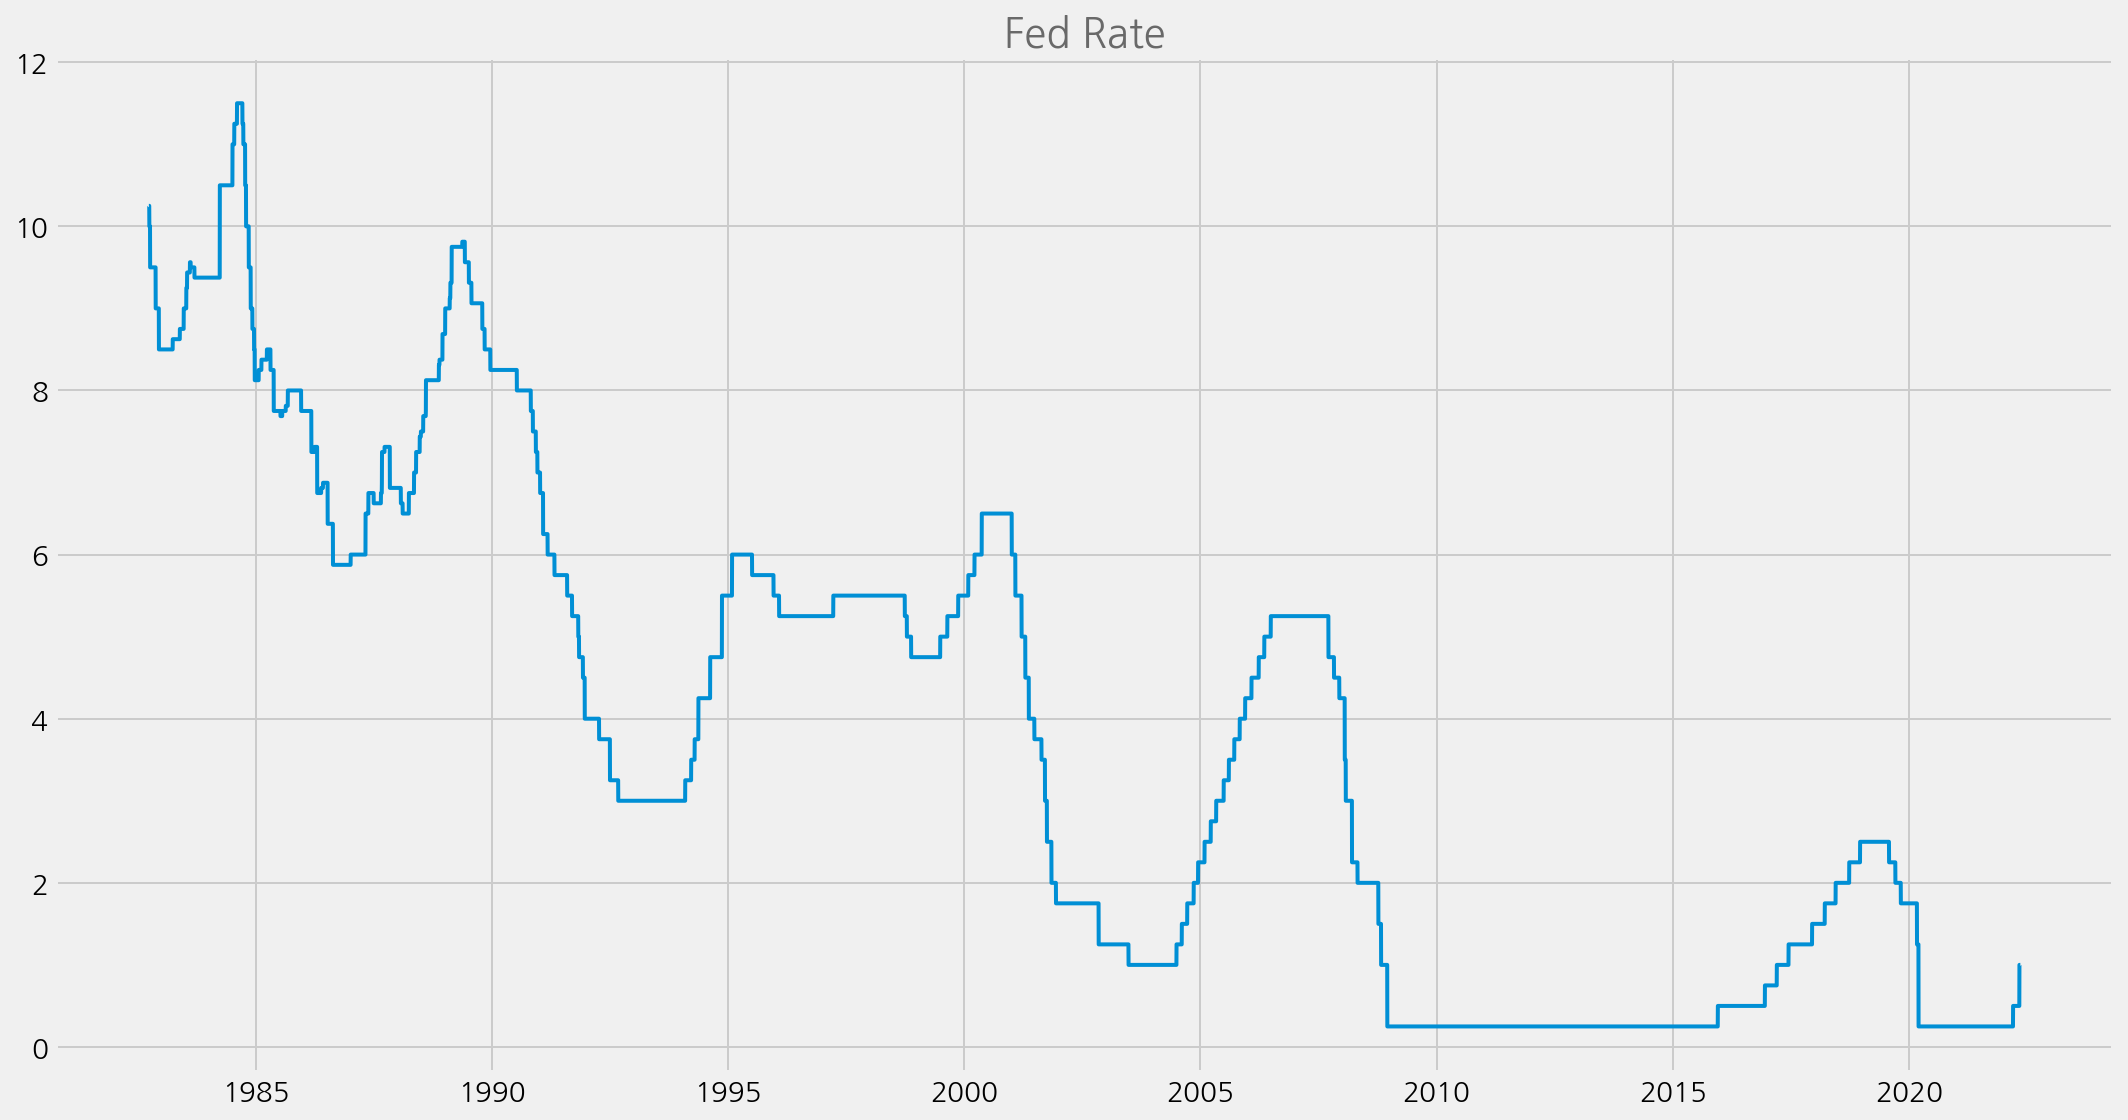

In [4]:
cfg = eKonf.compose(config_group='visualize/plot=lineplot')
cfg.dataset.y = 'fed_rate'
cfg.dataset.form = 'wide'
cfg.plots[0].y = 'fed_rate'
cfg.plot.figsize = (15, 8)
cfg.figure.title = 'Fed Rate'
eKonf.instantiate(cfg, data=FEDRATE)

## Load FOMC Corpus

In [5]:
from ekorpkit import eKonf

cfg = eKonf.compose(config_group='corpus=corpus')
cfg.name = 'fomc'
cfg.data_dir = "${cached_path:'https://github.com/entelecheia/ekorpkit-config/raw/main/data/fomc.zip',true,false}"
cfg.automerge = True
fomc = eKonf.instantiate(cfg)
print(fomc)

Corpus : fomc


In [6]:
print(fomc.data.content_type.unique())
fomc.data.head()

['fomc_minutes' 'fomc_statement' 'fomc_speech' 'fomc_beigebook'
 'fomc_testimony' 'fomc_press_conf' 'fomc_meeting_script']


,id,text,timestamp,content_type,date,speaker,title
0,0,A meeting of the Federal Open Market Committee...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes
1,1,A meeting of the Federal Open Market Committee...,1993-03-23,fomc_minutes,1993-03-23,Alan Greenspan,FOMC Meeting Minutes
2,2,A meeting of the Federal Open Market Committee...,1993-05-18,fomc_minutes,1993-05-18,Alan Greenspan,FOMC Meeting Minutes
3,3,A meeting of the Federal Open Market Committee...,1993-07-07,fomc_minutes,1993-07-07,Alan Greenspan,FOMC Meeting Minutes
4,4,A meeting of the Federal Open Market Committee...,1993-08-17,fomc_minutes,1993-08-17,Alan Greenspan,FOMC Meeting Minutes


In [7]:
fomc_statements = fomc.data[fomc.data.content_type == 'fomc_statement']
fomc_statements = fomc_statements[fomc_statements.timestamp.dt.year >= start_year]
fomc_statements.set_index('timestamp', inplace=True)
fomc_statements.head()

,id,text,content_type,date,speaker,title
timestamp,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement


## Predict setniments with the LM sentiment analyser

In [8]:
config_group='model/sentiment=lm'
model_cfg = eKonf.compose(config_group=config_group)
model_cfg.preprocessor.tokenizer.nltk.lemmatize = True

In [9]:
cfg = eKonf.compose(config_group='pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.model = model_cfg
cfg.output_dir = "./data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'
cfg.num_workers = 100
fomc_sentiments = eKonf.pipe(cfg, fomc_statements)
fomc_sentiments.head()

Predicting [text]: 100%|██████████| 91/91 [00:12<00:00,  7.15it/s]

 >> saved dataframe to ./data/predict/fomc_sentiments-lm.parquet


,id,text,content_type,date,speaker,title,positive,negative,num_tokens,polarity,subjectivity,polarity_label,uncertainty
timestamp,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,0.005004,0.017515,1199,-0.555556,0.022519,negative,0.019183
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,0.004847,0.016963,1238,-0.555556,0.021809,negative,0.018578
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,0.013962,0.022688,1146,-0.238095,0.036649,negative,0.020942
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,0.007042,0.007042,994,0.000000,0.014085,neutral,0.049296
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,0.007078,0.013145,989,-0.300000,0.020222,negative,0.033367


## Plot the sentiment scores

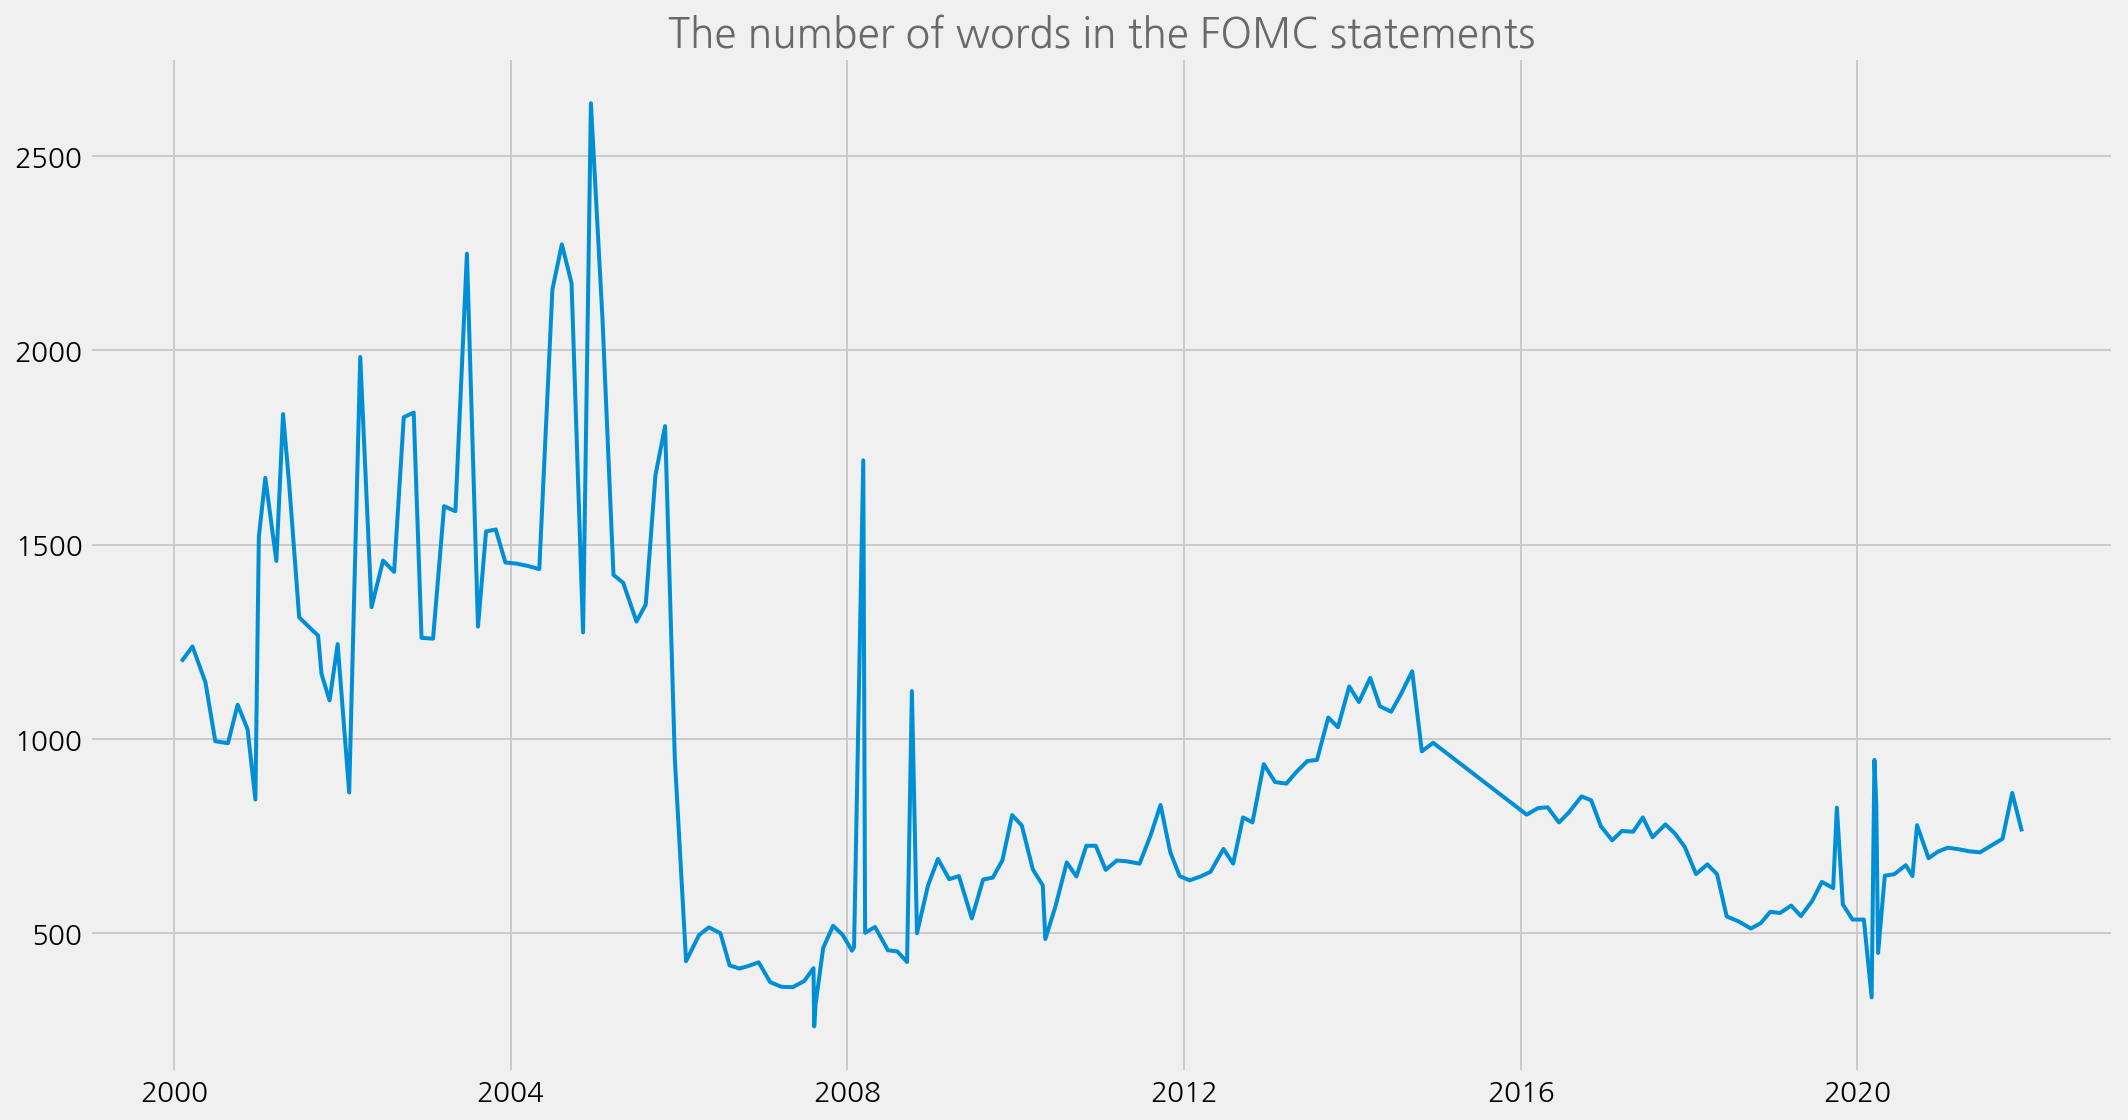

In [10]:
cfg = eKonf.compose(config_group='visualize/plot=lineplot')
cfg.dataset.y = 'num_tokens'
cfg.plot.figsize = (15, 8)
cfg.figure.title = 'The number of words in the FOMC statements'
cfg.figure.legend = None
eKonf.instantiate(cfg, data=fomc_sentiments)

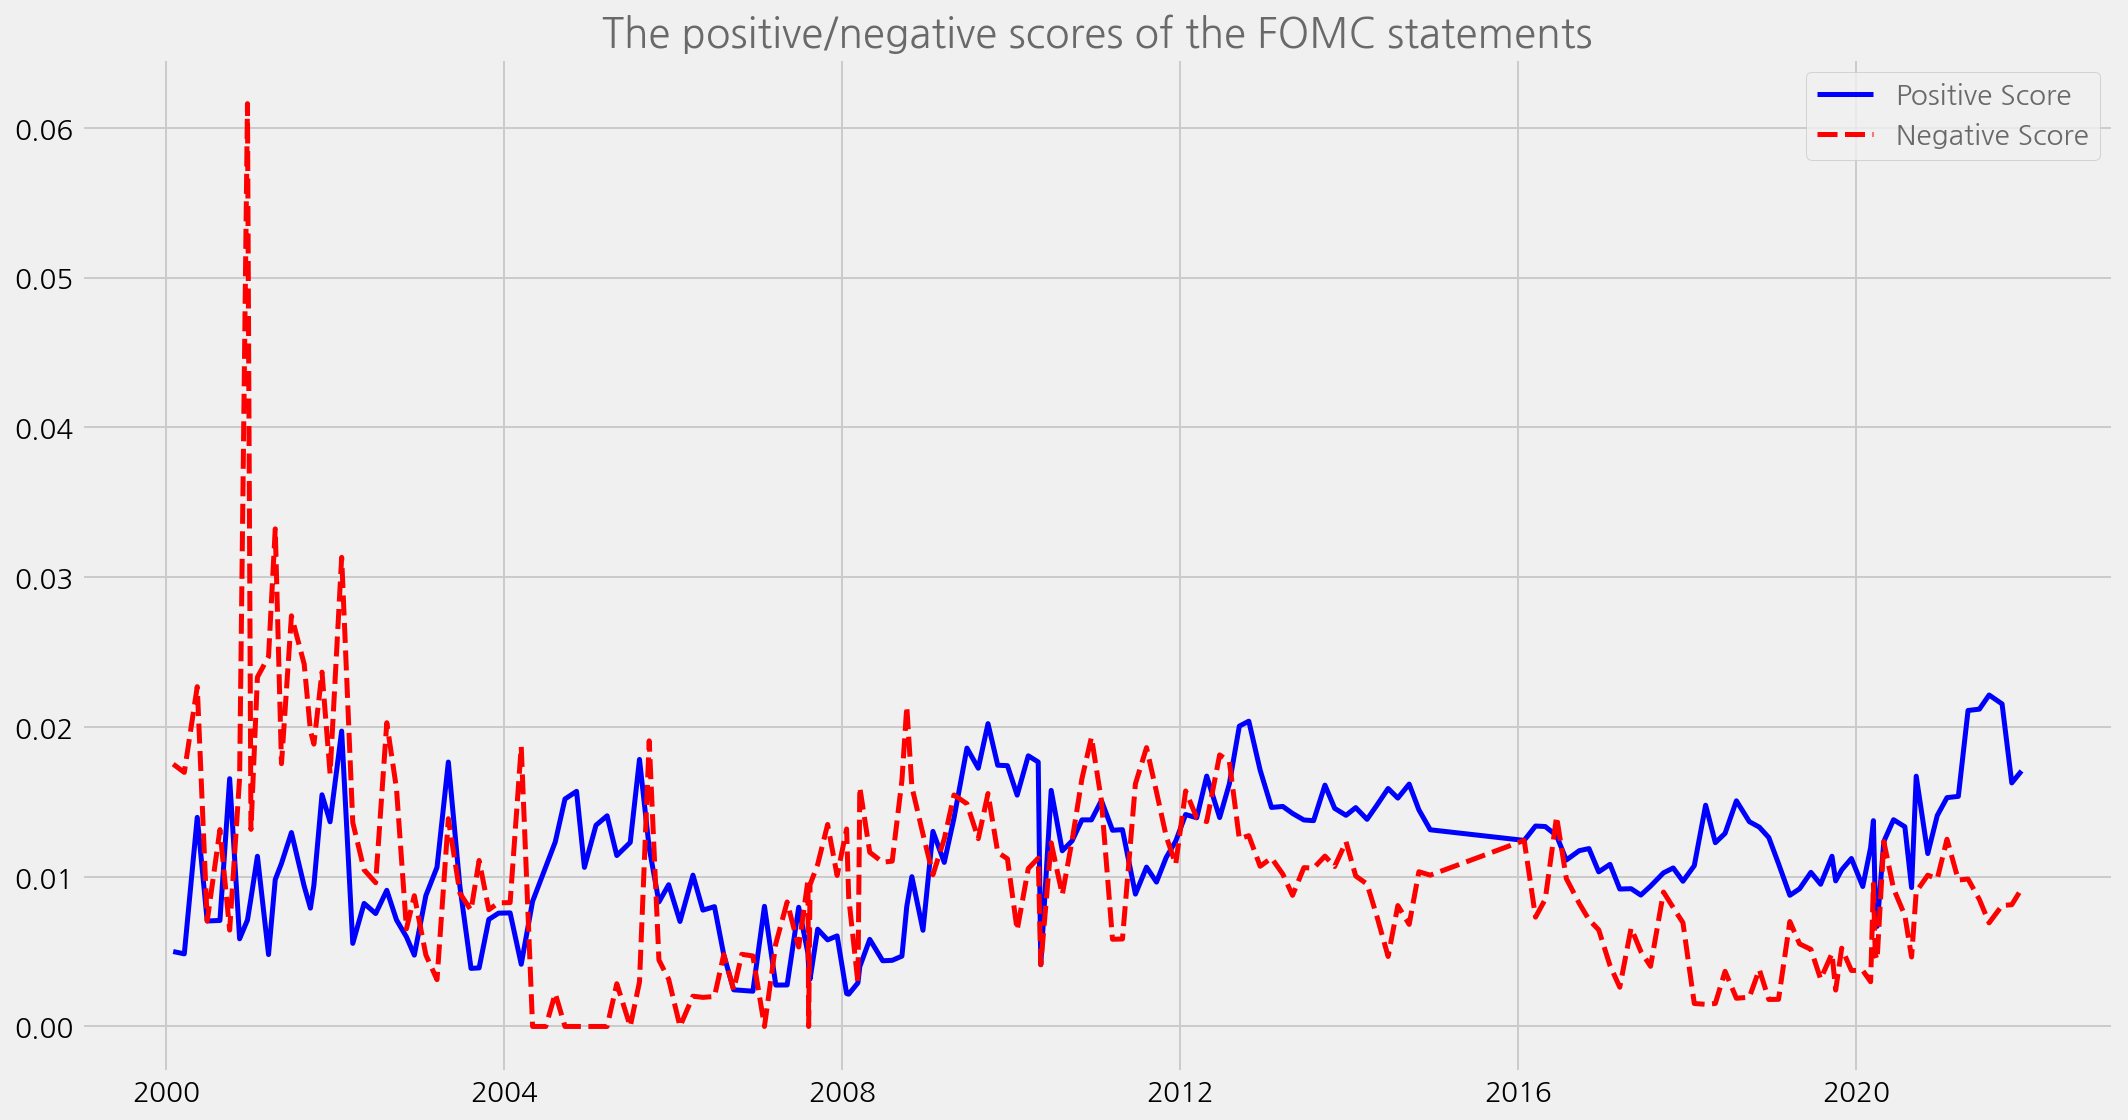

In [11]:
cfg = eKonf.compose(config_group="visualize/plot=lineplot")
cfg.dataset.y = ["positive", "negative"]
cfg.dataset.form = "wide"
cfg.plot.figsize = (15, 8)
cfg.lineplot.args.palette = ["b", "r"]
cfg.lineplot.args.linewidth = 2.5
cfg.figure.title = "The positive/negative scores of the FOMC statements"
cfg.figure.legend.labels = ["Positive Score", "Negative Score"]
# eKonf.print(cfg)
eKonf.instantiate(cfg, data=fomc_sentiments)

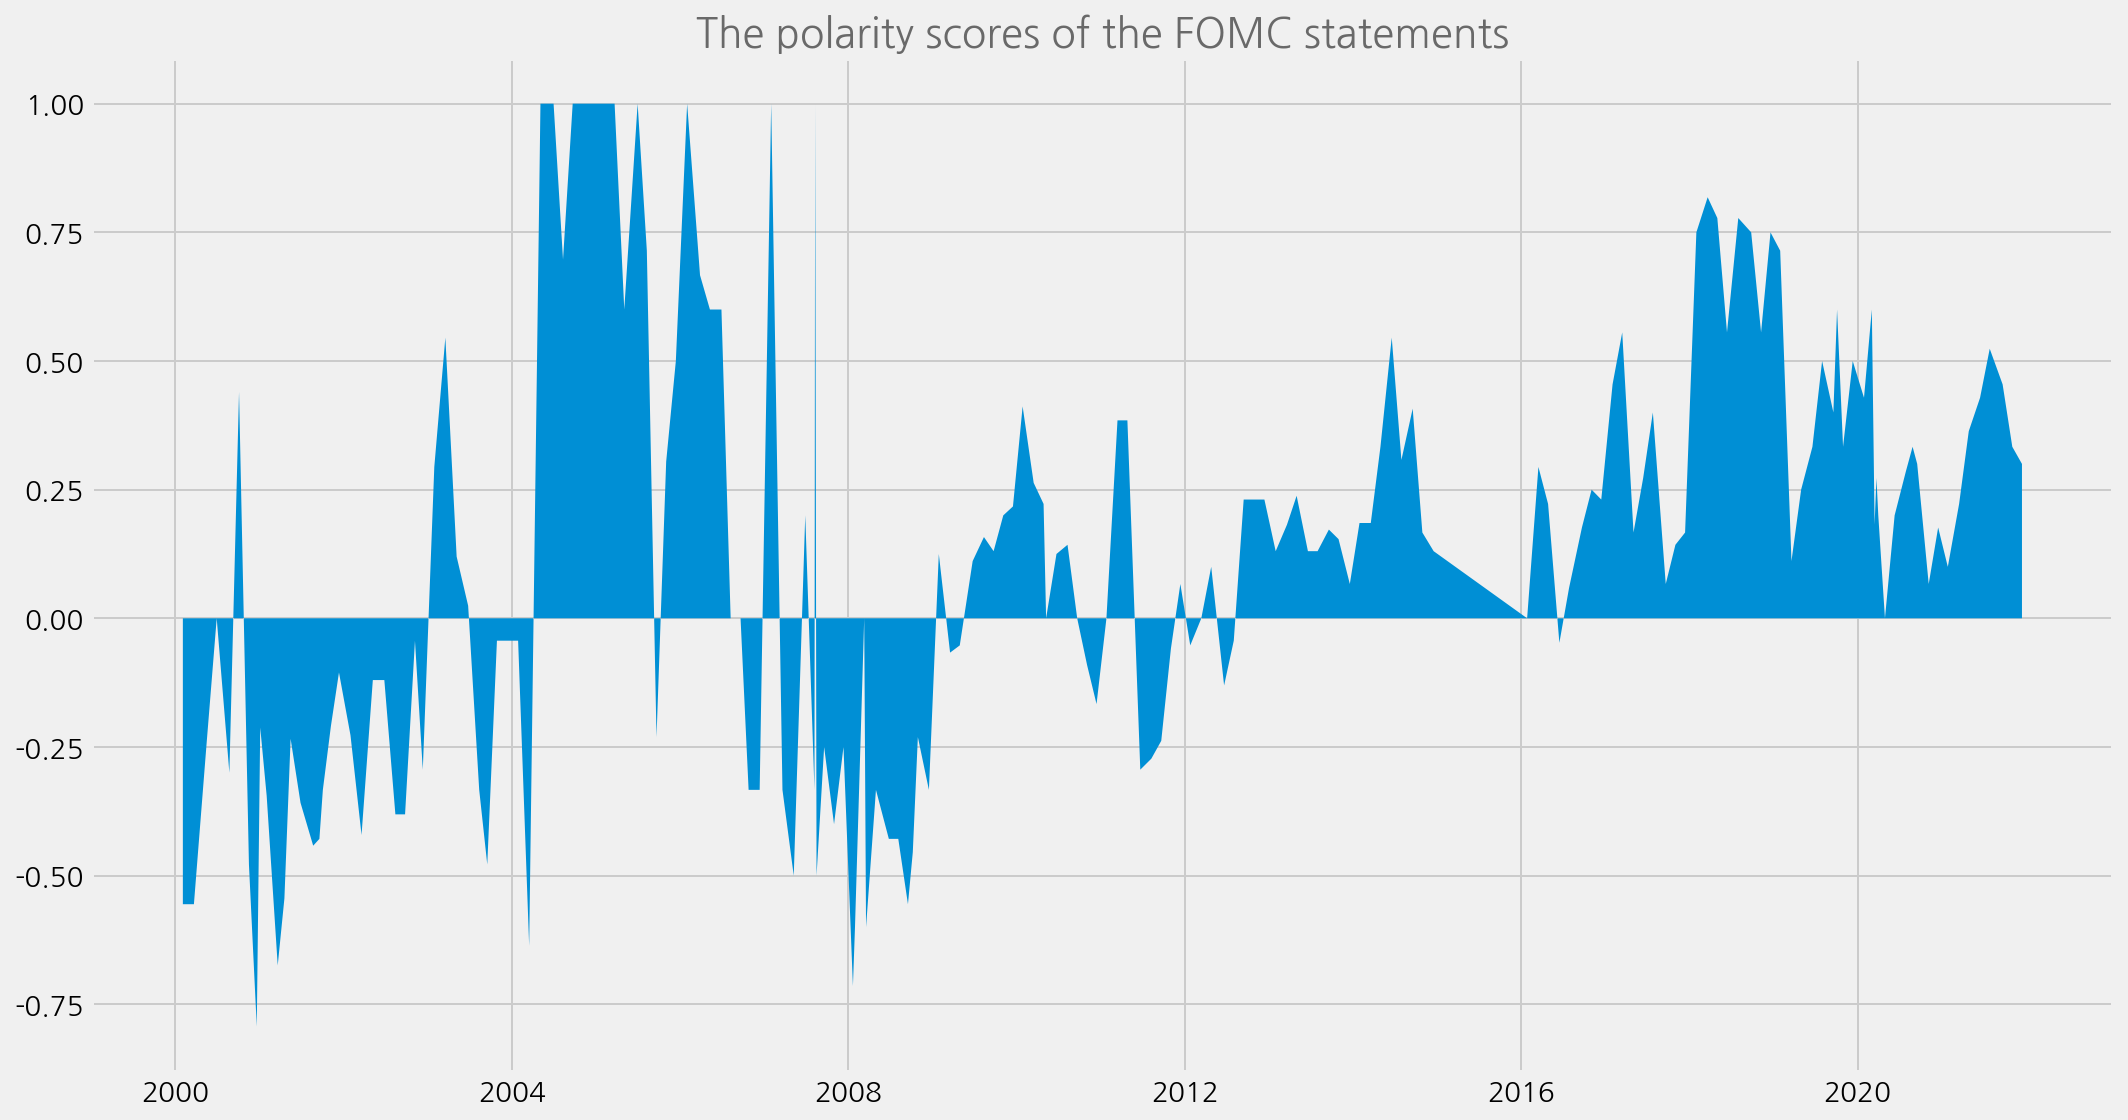

In [12]:
cfg = eKonf.compose(config_group='visualize/plot=stackplot')
cfg.dataset.y = 'polarity'
cfg.plot.figsize = (15, 8)
cfg.figure.title = 'The polarity scores of the FOMC statements'
cfg.figure.xtickmajorformatterfunc = "mdates.DateFormatter('%Y')"
eKonf.instantiate(cfg, data=fomc_sentiments)


### Merge with fed rate data

In [13]:
fomc_sentiments = fomc_sentiments.merge(FEDRATE, left_index=True, right_index=True)
fomc_sentiments.head()

,id,text,content_type,date,speaker,title,positive,negative,num_tokens,polarity,subjectivity,polarity_label,uncertainty,fed_rate,direction
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,0.005004,0.017515,1199,-0.555556,0.022519,negative,0.019183,5.75,1
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,0.004847,0.016963,1238,-0.555556,0.021809,negative,0.018578,6.00,1
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,0.013962,0.022688,1146,-0.238095,0.036649,negative,0.020942,6.50,1
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,0.007042,0.007042,994,0.000000,0.014085,neutral,0.049296,6.50,0
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,0.007078,0.013145,989,-0.300000,0.020222,negative,0.033367,6.50,0


### Plot the results and compare to the economical uncertainty / systemic risk periods

In [14]:
from datetime import datetime

args = eKonf.compose(config_group='fetch/fetcher=fomc')
recessions = args.recessions

span_args = eKonf.compose(config_group='visualize/plot/axvspan', return_as_dict=True)
annot_args = eKonf.compose(config_group='visualize/plot/annotation', return_as_dict=True)
span_args["color"] = "crimson"
span_args["alpha"] = 0.4

spans = []
annotations = []
for name, span in recessions.items():
    annotation = span["name"]
    start = datetime.strptime(span["from"], span["format"])
    end = datetime.strptime(span["to"], span["format"])
    span = {'xmin': start, 'xmax': end}
    span = {**span_args, **span}

    x = start + (end - start) / 2
    y = -0.75
    annot = {'text': annotation, 'xy': (x, y), 'xytext': (x, y)}
    annot = {**annot_args, **annot}

    spans.append(span)
    annotations.append(annot)


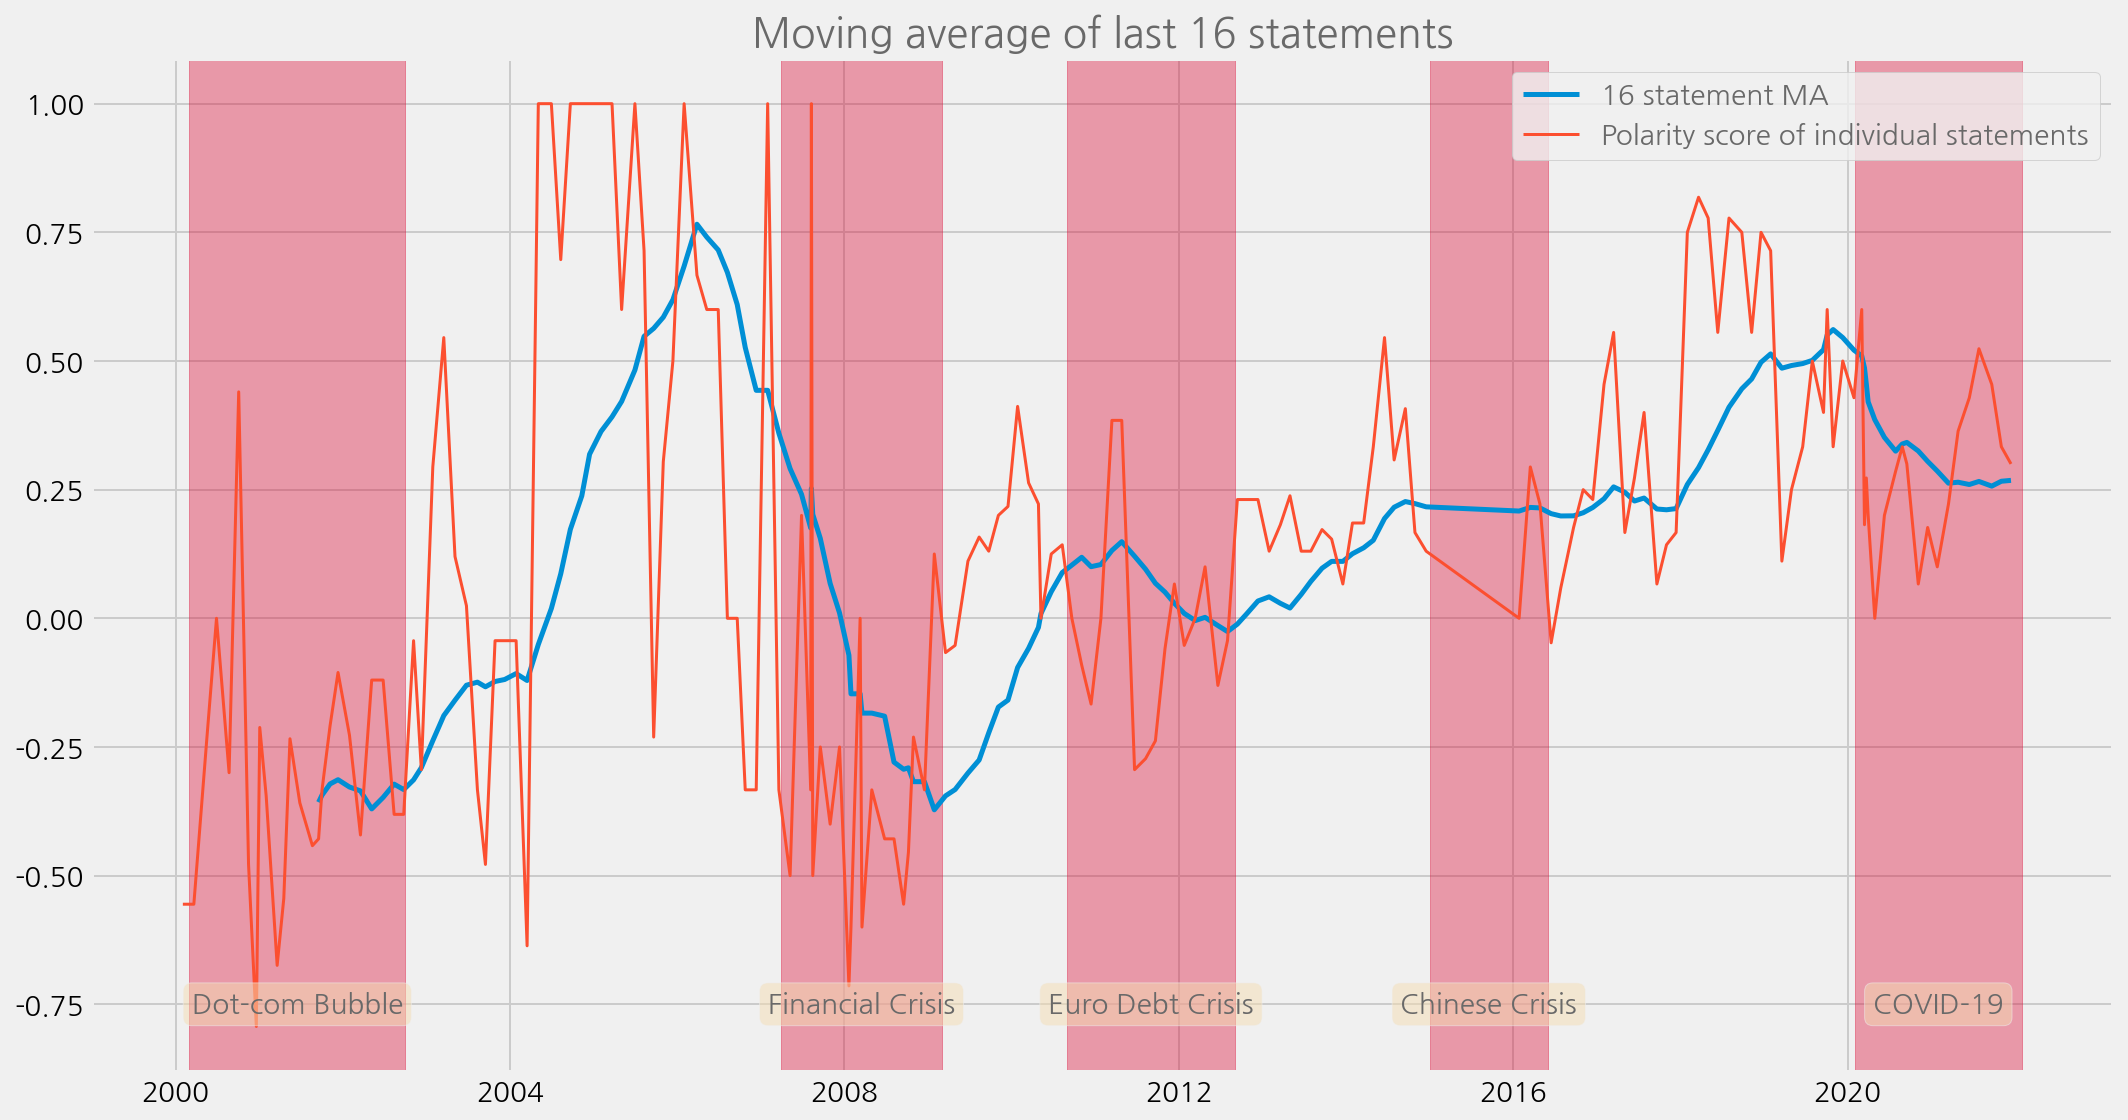

In [15]:
window = 16
fomc_sentiments['polarity_ma'] = fomc_sentiments.polarity.rolling(window).mean()

cfg = eKonf.compose(config_group="visualize/plot=lineplot")
cfg.dataset.form = "individual"
cfg.plot.figsize = (15, 8)
cfg.plots.append(cfg.lineplot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].args.linewidth = 2.5
cfg.plots[0].args.palette = "r"
cfg.plots[1].y = "polarity"
cfg.plots[1].args.linewidth = 1.5
cfg.plots[1].args.palette = "g"
cfg.figure.title = f"Moving average of last {window} statements"
cfg.figure.legend.labels = [
    f"{window} statement MA",
    "Polarity score of individual statements",
]
eKonf.instantiate(cfg, data=fomc_sentiments, annotations=annotations, axvspans=spans)

In [16]:
args = eKonf.compose(config_group='fetch/fetcher=fomc')
chair = pd.DataFrame(**args.fomc.chair)
chair['from_date'] = pd.to_datetime(chair['from_date'])
chair['to_date'] = pd.to_datetime(chair['to_date'])
chair.head()

annot_args = eKonf.compose(config_group='visualize/plot/annotation', return_as_dict=True)

spans = []
annotations = []
for row in chair.iterrows():
    row_num = row[0]
    start = row[1]['from_date'].to_pydatetime()
    if start.year < 2000:
        start = datetime(2000, 1, 1)    
    end = row[1]['to_date'].to_pydatetime()
    annotation = row[1]['surname']
    color = 'crimson' if row_num % 2 == 0 else 'darkblue'
    alpha = 0.4 if row_num % 2 == 0 else 0.0
    span = {'xmin': start, 'xmax': end, 'alpha': alpha, 'color': color}

    x = start + (end - start) / 2
    y = -0.75
    annot = {'text': annotation, 'xy': (x, y), 'xytext': (x, y)}
    annot = {**annot_args, **annot}

    spans.append(span)
    annotations.append(annot)

Creating secondary axis
Saved figure to ./figs/lineplot.png


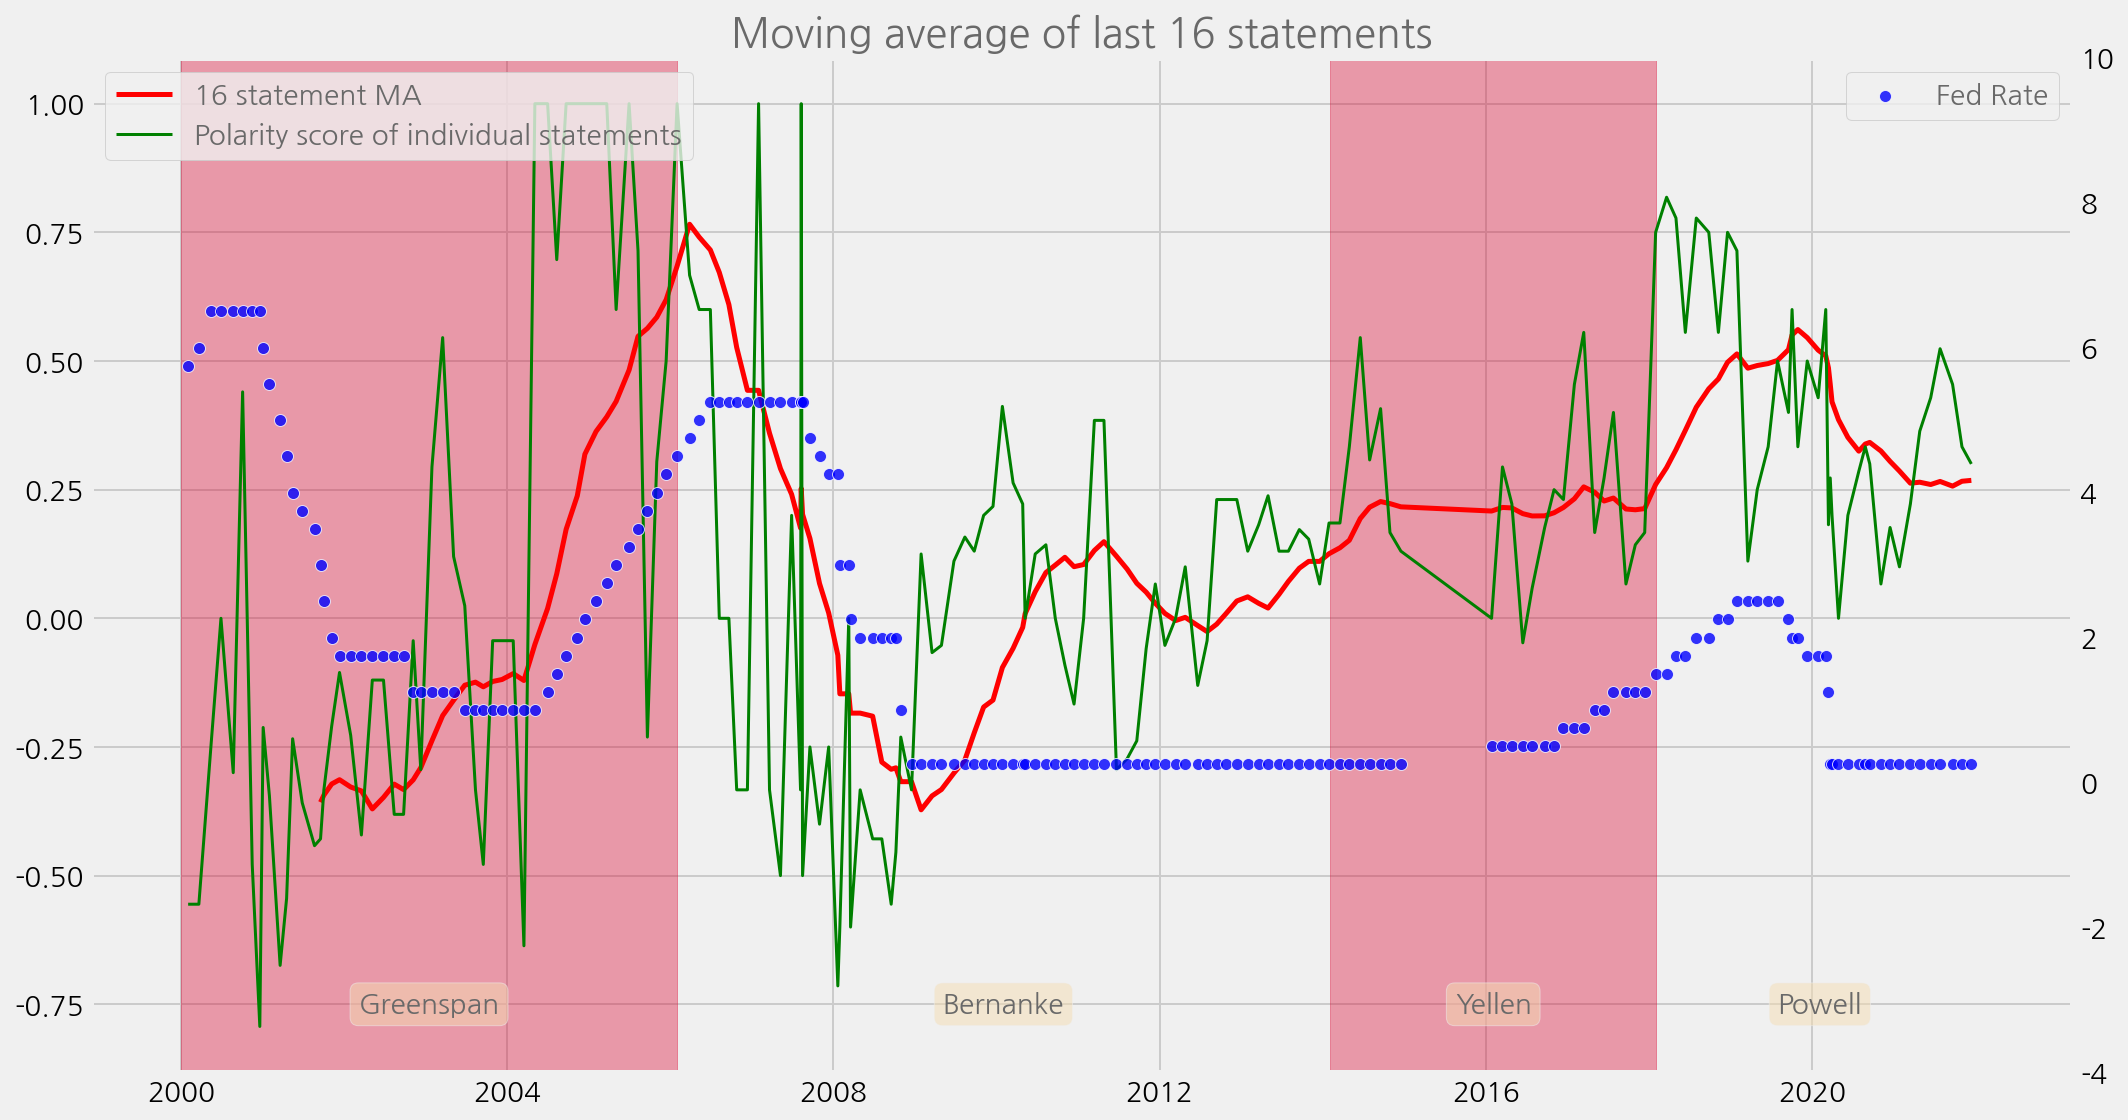

In [20]:
cfg = eKonf.compose(config_group="visualize/plot=lineplot")
figure2 = cfg.figure.copy()

cfg.dataset.form = "individual"
cfg.plot.figsize = (15, 8)
cfg.plots.append(cfg.lineplot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].args = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "polarity"
cfg.plots[1].args = dict(linewidth=1.5, color="green")
cfg.figure.title = f"Moving average of last {window} statements"
cfg.figure.legend = dict(
    labels=[
        f"{window} statement MA",
        "Polarity score of individual statements",
    ],
    loc=2,
)
scatter_cfg = eKonf.compose(config_group="visualize/plot/scatter")
scatter_cfg.y = "fed_rate"
scatter_cfg.secondary_y = True
scatter_cfg.args = dict(color="blue", alpha=0.8)
cfg.plots.append(scatter_cfg)
cfg.verbose = True

figure2.grid = False
figure2.ylim = "(-4, 10)"
figure2.legend = dict(
    labels=["Fed Rate"],
    loc=1,
)

eKonf.instantiate(
    cfg, data=fomc_sentiments, annotations=annotations, axvspans=spans, figure2=figure2
)
